# Paper replication

This project is a replication attempt of results of figure 2.a found in the paper "E. Cho, S. A. Myers, and J. Leskovec, ‘Friendship and mobility: user movement in location-based social networks’, in Proceedings of the 17th ACM SIGKDD international conference on Knowledge discovery and data mining - KDD ’11, San Diego, California, USA, 2011, p. 1082, doi: 10.1145/2020408.2020579."


#  1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os
# Library to compute distances between users' homes using Latitude Longitude coordinates
from geopy import distance
from haversine import haversine_vector, Unit
# Libraries to plot users locations on a map
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#  2. Importing Data from data folder

In [2]:
# Data folder path
DATA_FOLDER_PATH = "../data"
# Look for compressed files in this folder and save them in paths
paths = [os.path.join(DATA_FOLDER_PATH,f) for f in os.listdir(DATA_FOLDER_PATH) if f.endswith('.gz')]
# Printing paths to check if all folders are there
paths

['../data/loc-gowalla_totalCheckins.txt.gz',
 '../data/loc-brightkite_edges.txt.gz',
 '../data/loc-brightkite_totalCheckins.txt.gz',
 '../data/loc-gowalla_edges.txt.gz']

In [3]:
# import gowalla_totalcheckins data
df_gowalla_totalCheckins = pd.read_csv(paths[0],sep='\t',compression='gzip',header=None,
                                       names=['user','check-in_time','latitude','longitude','location_id'])

In [4]:
# Printing gowalla check-ins dataframe 
df_gowalla_totalCheckins.head()

,user,check-in_time,latitude,longitude,location_id
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [5]:
# Dropping location_id and check-in_time as it's not needed for our replication
df_gowalla_totalCheckins.drop(columns=['check-in_time','location_id'],inplace=True)

In [6]:
# import brightkite_totalCheckins data
# Similarely, we set the columns name as explained in the dataset informations
df_brightkite_totalCheckins = pd.read_csv(paths[2],sep='\t',compression='gzip',header=None,
                                       names=['user','check-in_time','latitude','longitude','location_id'])

In [7]:
# Printing brightkite check-ins dataframe 
df_brightkite_totalCheckins.head()

,user,check-in_time,latitude,longitude,location_id
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc


In [8]:
# Dropping location_id and check-in_time as it's not needed for our replication
df_brightkite_totalCheckins.drop(columns=['check-in_time','location_id'],inplace=True)

In [9]:
# import gowalla_edges data
# There is no header in the file, we explicetly name the columns
df_gowalla_edges = pd.read_csv(paths[3],sep='\t',compression='gzip',header=None,names=['user1','user2'])

In [10]:
# Display gowalla edges. Each edge represent a friendship between two users
df_gowalla_edges.head()

,user1,user2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [11]:
# import brightkite_edges data
# Similarely, we explicetly name the columns
df_brightkite_edges = pd.read_csv(paths[1],sep='\t',compression='gzip',header=None,names=['user1','user2'])

In [12]:
# Display brightkite edges. Each edge represent a friendship between two users
df_brightkite_edges.head()

,user1,user2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


#  3. Data Cleaning


First, let's plot the distributions of longitude and latitude for each dataset.
- Note that we sample 10% of each dataset to make the computation faster 

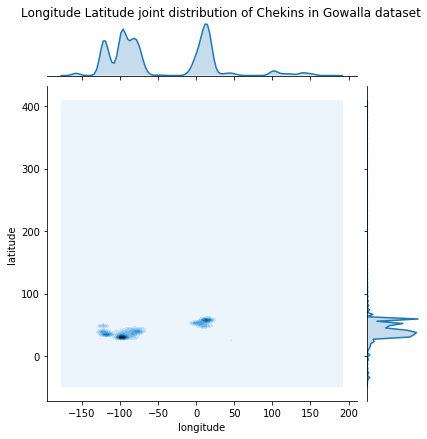

In [13]:
sns.jointplot(data = df_gowalla_totalCheckins.sample(frac=0.1), y = 'latitude', x = 'longitude', kind="kde")
plt.title('Longitude Latitude joint distribution of Chekins in Gowalla dataset',loc='right',pad=70)
plt.show()

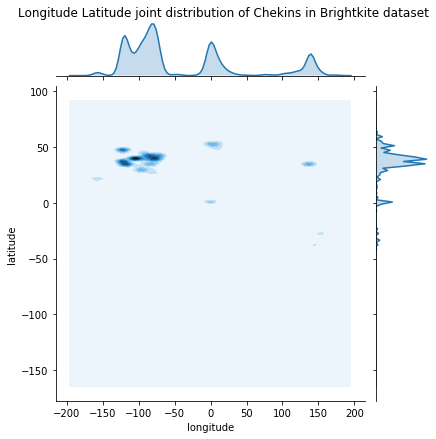

In [14]:
sns.jointplot(data = df_brightkite_totalCheckins.sample(frac=0.1), y = 'latitude', x = 'longitude', kind="kde")
plt.title('Longitude Latitude joint distribution of Chekins in Brightkite dataset',loc='right',pad=70)
plt.show()

Note that in each dataset, we can see a concentration of latitude,longitude at 0. We will consider them as erronous data and delete them later.
Moreover, we can see that both longitude $\phi$ and latitude $\lambda $ exceed their standard limits which are $\phi \in [-180,180] $ and $\lambda \in [-90,90]$ We need to correct these values while keeping the same longitude\latitude lines identifications.

## 3.1 Latitude Longitude Correction

* Latitude must be between [-90,90] degrees and [-180,180] for the longitude.
* We need to check this in each checkins' dataframe

Latitude identification is symmetric with respect to the y axis. For example, $\lambda = 80°$ and $\lambda = 100°$ represent the same latitude line. 
Therefore, to correct this feature, we simply substract or add 180° depending on its sign and invert the sign of the result. This is equivalent to the desired symmetry.

In [15]:
def correct_latitude(lat):
    """
    This function corrects for out of range latitude.
    
    Input: 
    -- lat: latitude coordinates in °
    Output: 
    -- lat: latitude coordinates put between -90 and 90°
    """
    while lat>90 or lat<-90:
        if lat>90:
            lat = -(lat-180)
        elif lat<-90:
            lat = -(lat+180)
    return lat

For the Longitude correction, we simply add or substract 360° which keeps the same angle properties.

In [16]:
def correct_longitude(long):
    """
    This function corrects for out of range longitude.
    
    Input: 
    -- long: longitude coordiantes in °
    Output: 
    -- long: longitude coordinates put between -180 and 180°
    """
    while long>180 or long<-180:
        if long>180:
            long = long - 360
        elif long<-180:
            long = long +360
    return long

### 3.1.1. Gowalla check-ins dataset

In this step we will verify if the latitude and longitude data are in the correct range. We will manually check for erroneous data and correct it using previously defined functions. We will be also deleting rows containing nan values

In [17]:
df_gowalla_totalCheckins[(df_gowalla_totalCheckins.latitude<-90)|(df_gowalla_totalCheckins.latitude>90)].head()

,user,latitude,longitude
3795278,59536,405.550734,151.331785
3795280,59536,404.629219,152.464940
3795299,59536,405.646925,151.255792
3795312,59536,405.658498,151.256815
3795317,59536,405.624976,151.234238


In [18]:
# Correction of latitude
df_gowalla_totalCheckins.latitude = df_gowalla_totalCheckins.latitude.apply(correct_latitude)

In [19]:
# Verification if latitude is corrected
df_gowalla_totalCheckins[(df_gowalla_totalCheckins.latitude<-90)|(df_gowalla_totalCheckins.latitude>90)].head()

,user,latitude,longitude


In [20]:
# Check for out of range longitude in gowalla checkins
df_gowalla_totalCheckins[(df_gowalla_totalCheckins.longitude<-180)|(df_gowalla_totalCheckins.longitude>180)].head()

,user,latitude,longitude


In [21]:
#drop nan values
df_gowalla_totalCheckins.dropna(inplace=True)

In [22]:
df_gowalla_totalCheckins = df_gowalla_totalCheckins[(df_gowalla_totalCheckins['latitude'] !=0) & 
                                                    (df_gowalla_totalCheckins['longitude'] != 0)]

### 3.1.2. Brightkite check-ins dataset

We will repeat the same steps we followed previously on Brightkite

In [23]:
df_brightkite_totalCheckins[(df_brightkite_totalCheckins.latitude>90)|(df_brightkite_totalCheckins.latitude<-90)].head()

,user,latitude,longitude
203793,271,-94.578567,39.099727
203794,271,-94.578567,39.099727
203795,271,-94.578567,39.099727
203796,271,-94.578567,39.099727
1824796,7433,-163.193333,-18.060833


In [24]:
# Correction of latitude
df_brightkite_totalCheckins.latitude = df_brightkite_totalCheckins.latitude.apply(correct_latitude)

In [25]:
# Verification if latitude is corrected
df_brightkite_totalCheckins[(df_brightkite_totalCheckins.latitude>90)|
                            (df_brightkite_totalCheckins.latitude<-90)].head()

,user,latitude,longitude


In [26]:
# Check for out of range longitude in Brightkite checkins
df_brightkite_totalCheckins[(df_brightkite_totalCheckins.longitude<-180)|
                            (df_brightkite_totalCheckins.longitude>180)].head()

,user,latitude,longitude


In [27]:
#drop nan values
df_brightkite_totalCheckins.dropna(inplace=True)

In [28]:
df_brightkite_totalCheckins = df_brightkite_totalCheckins[(df_brightkite_totalCheckins['latitude'] !=0) & 
                                                          (df_brightkite_totalCheckins['longitude'] != 0)]

## 3.2. Friendships duplicated edges

As friendship relations are mutual, we don't want to keep duplicates. For example, if user1 is friend with user2, user2 is also a friend of user1. We want to keep only one undirected edge.

To do that, we first compute the maxmimum number of digits of the user_id, call it "n". We will then convert each user id to a string of length n. Next, we will concatenate these to "strings" in sorted order so that if we swap users id we will keep the same concatenated string.

It is important to compute the "n" to avoid some collisions. For example, a string "2332" can be the result of user1 = 23, user2= 32, or user1= 2 and user2 = 332. However, if we fix the length of the string, say 6, we will get a '000023000032' for the first case and '000002000332' and the problem is solved.

### 3.2.1 Gowalla edges

In [29]:
df_gowalla_edges = df_gowalla_edges[df_gowalla_edges['user1']<df_gowalla_edges['user2']]

### 3.2.2 Brightkite edges

In [30]:
df_brightkite_edges = df_brightkite_edges[df_brightkite_edges['user1']<df_brightkite_edges['user2']]

# 4. Compute distribution between friends homes

## 4.1. Compute home position for every user in each dataset

Now that latitude and longitude coordinates are corrected and put on the right range, we will descretize the world into 25x25 $km^2$ and compute the user average position in the most visited square. This will help us approximate users' homes positions. We will do the same operations on each check-ins dataset

## 4.2. Discretizing the world

We know that the earth is not a perfect sphere. However, the difference between the circonference around the poles (40,007 km) and around the equator (40,075 km) is very small (around 0.16%). Therefore, we can approximate Earth as a perfect sphere of diameter 40000 km. 

Moreover, as the latitude sits between [-90,90] and latitude lines go through earth poles we can compute easily compute $\Delta \lambda$ the angle step that results to 25km edge which is equal to the following expression:

\begin{equation}
\Delta \lambda = \frac{180}{40000/(2*25)} = 0.225^{o}
\end{equation}

However, for the longitude, we should take into account the latitude angle. We should first compute the resulting the new perimeter which can be simply computed using the following equation:

\begin{equation}
P_{\lambda} = cos(\lambda)*P_{Earth}
\end{equation}

Using this new perimeter, we can compute $\Delta \phi$ the angle step along a longitudinal line that results into a 25km edge.

\begin{equation}
\Delta \phi(\lambda) = \frac{360}{P_{\lambda}/25}
\end{equation}


Note that we slightly change the earth diameter to obtain round values. This should not affect the quality of our discretizing as we approximately loose only 4.375m  along a latutide line in each cell which represents 0.017% of 25km edge of our square.

We also note that it is not possible to precisely divide the surface of a sphere with equaly sized squares without any undesired distorsion. Recall that what we want to do is approximate users' homes location so we assume that our approximation is quite good.

In [31]:
# Preparing arrays for discretizing the world
# This arrays will be passed as arguments to the aggregation function which will avoid making unnecessary
# computations each time we call the function

EARTH_PERIMETER = 40000
# Compute number of 25km steps of half of the perimeter of earth
n_lat = int((EARTH_PERIMETER/2)/25)
# Compute delta_lat which corresponds to a latitude angle step to obtain 25km
delta_lat = 180/n_lat
# Discretized Latitdue. Each step correspond to 25km along a latitudinal geodesic
discretized_lat = np.arange(-90,90 + delta_lat,delta_lat)
# Compute deltas_long which corresponds to list containing longitudinal angle steps for different latitudes
deltas_long = []
for lat in discretized_lat:
    # Compute perimeter of the earth for a given latitude angle
    perimeter_in_lat = np.cos(np.deg2rad(lat))*EARTH_PERIMETER
    # Compute number of 25km steps along the previously calculated perimeter
    n_long = int(round(perimeter_in_lat/25))
    
    # n_long can be 0 if latitude is 90 or -90
    # If n_long is 0, we chose delta_long = 999 which is impossible to have since the longitude 
    # sits between [-180,180]
    if n_long == 0:
        delta_long = 999
    else:
    # else compute delta_long
        delta_long = 360/n_long
    # Append delta_long to deltas_long list    
    deltas_long.append(delta_long)

## 4.3. Checking our discretizing

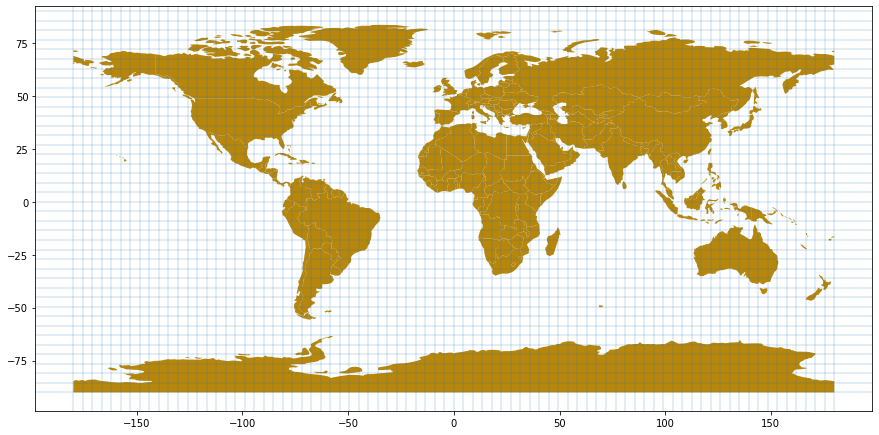

In [32]:
# select map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# define ax and plot the map
ax = world.plot(figsize=(15, 9), color = 'darkgoldenrod')
for i in range(len(discretized_lat)):
    # Plotting all latitiudinal lines would result to an unclear plot. We plot every 20 points
    if i%20 == 0:
        ax.axhline(discretized_lat[i],linewidth=0.25)
        # Compute a discretized longitudinal array
        discretized_long = np.arange(-180,180 + deltas_long[i],deltas_long[i])
        for j in range(len(discretized_long)):
            # Similarely, we plot every 20 points
            if j%20 == 0:
                ax.axvline(discretized_long[j],discretized_lat[i],discretized_lat[i]+20*delta_lat,linewidth=0.25)


## 4.4. Defining a function to compute users' home location

In [33]:
def compute_home_position(df, delta_lat, deltas_long):
    """
    This function takes the check-ins of a user and discretitze the world to 25x25km^2
    It looks for the square where there is the most check-ins
    compute the average location in that square which is considered as the home location
    
    Input: 
    -- df :Dataframe containing latitude and longitude columns
    -- delta_lat: Latitude angle step
    -- deltas_long: An array containing longitude angle step for different latitude angles
    
    Output: An aggregation containing the home_latitude and home_longitude
    -- home_latitude: an estimation of user's home latitude
    -- home_longitude: an estimation of user's home longitude
    """
    n = len(deltas_long)
    #Preparing counting array
    counting = np.zeros((n,2*n))
    mask = np.empty((n,2*n),dtype=object)
    latitude = df.latitude.values
    longitude = df.longitude.values
    for i in range(len(df)):
        # Compute the index of discretized latitude
        # We add 90 to obtain positive integers. Recall latitude sits between [-90,90]
        j = int(round((latitude[i] + 90)/delta_lat))
        # Compute the index of discretized longitude 
        # We add 180 to obtain positive integers. Recall longitude sits between [-180,180]
        k = int(round((longitude[i] + 180)/deltas_long[j]))
        # Increase counter in the counting array
        counting[j,k]+=1
        #track the locations that led to an increase in the the counting array
        mask[j,k] = np.append(mask[j,k],i)
    
    # Find the square with most visits
    max_index = np.unravel_index(np.argmax(counting),counting.shape)
    # Build a df_mask to retrace locations in the most visited square
    df_mask = list(mask[max_index])[1:]
    
    # Compute average latitidue in that square
    home_latitude = np.mean(df.latitude.iloc[df_mask])
    # Compute average longitude in that square
    home_longitude = np.mean(df.longitude.iloc[df_mask])
    
    return home_latitude,home_longitude

## 4.5. Plotting a selected user's location on a map
First let's check the check-ins of one user

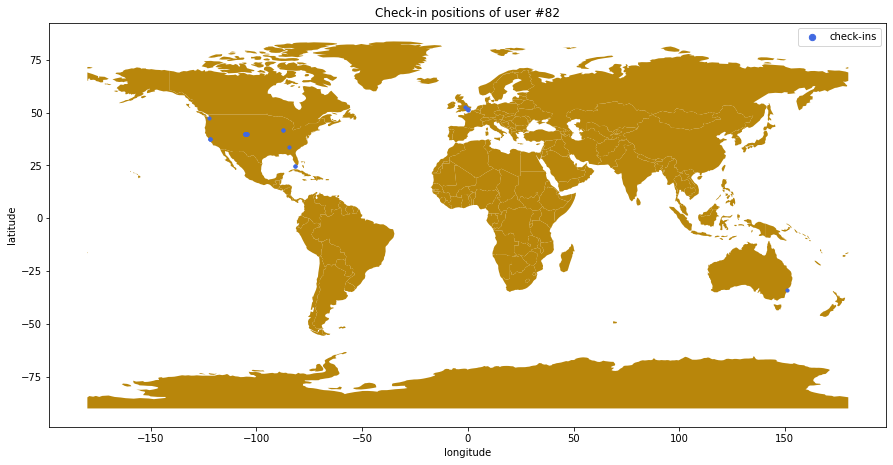

In [34]:
# select user index to track its check-ins and home location
user_index = 82
# select user's raw check-ins data 
user_0  =  df_brightkite_totalCheckins.groupby(by='user').get_group(user_index)
# compute geometry to plot locations on world map and build dataframe
geometry = [Point(xy) for xy in zip(user_0['longitude'], user_0['latitude'])]
gdf = GeoDataFrame(user_0, geometry=geometry) 
# select map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# define ax and plot the map
ax = world.plot(figsize=(15, 9), color = 'darkgoldenrod')
# plot check-ins
gdf.plot(ax=ax, marker='.', color='royalblue', markersize=40);
# plot home location

plt.ylabel('latitude')
plt.xlabel('longitude')
plt.title('Check-in positions of user #{}'.format(user_index))
plt.legend(['check-ins'],markerscale=2)

### 4.6. Computing home positions

In [35]:
# Computing average home position for BrightKite dataset
users_brightkite_home_location = df_brightkite_totalCheckins.groupby(by='user')\
                                .agg(compute_home_position,delta_lat,deltas_long)
users_brightkite_home_location.head()

,latitude,longitude
user,,
0,39.782612,-105.003885
1,37.602449,-122.381606
2,39.776274,-105.010043
3,37.767867,-122.424768
4,60.171638,24.936969


In [36]:
# Computing average home position for Gowalla dataset
users_gowalla_home_location = df_gowalla_totalCheckins.groupby(by='user')\
                                .agg(compute_home_position,delta_lat,deltas_long)
users_gowalla_home_location.head()

,latitude,longitude
user,,
0,30.273455,-97.749247
1,44.724746,5.032961
2,37.840347,-122.250501
4,37.777994,-122.437533
5,30.292597,-97.734593


## 4.7. Checking home positions of a user

* Checking home position for different users

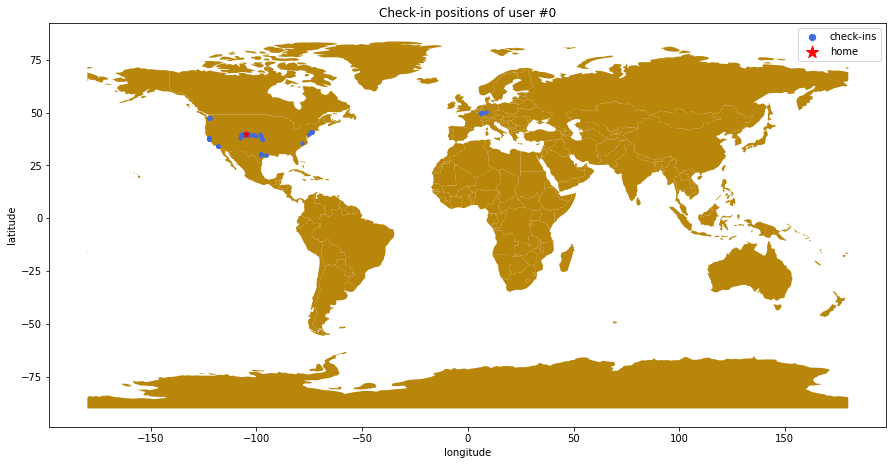

In [37]:
# select user index to track its check-ins and home location
user_index = 0
# select user home location (brightkite dataset is used for this example)
user_home = users_brightkite_home_location[['longitude','latitude']].iloc[user_index].values
# select user's raw check-ins data 
user_0  =  df_brightkite_totalCheckins.groupby(by='user').get_group(user_index)
# compute geometry to plot locations on world map and build dataframe
geometry = [Point(xy) for xy in zip(user_0['longitude'], user_0['latitude'])]
gdf = GeoDataFrame(user_0, geometry=geometry) 
# build dataframe for home location
home_df  = GeoDataFrame(users_gowalla_home_location.iloc[user_index].to_frame().transpose()[['longitude','latitude']]
                       ,geometry=[Point(user_home)])
# select map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# define ax and plot the map
ax = world.plot(figsize=(15, 9), color = 'darkgoldenrod')
# plot check-ins
gdf.plot(ax=ax, marker='.', color='royalblue', markersize=40);
# plot home location
home_df.plot(ax=ax, marker='*', color='red', markersize=40)

plt.ylabel('latitude')
plt.xlabel('longitude')
plt.title('Check-in positions of user #{}'.format(user_index))
plt.legend(['check-ins','home'],markerscale=2)

# 4.8. Extend social network edges using the check-ins dataset

As explained previously, the edges of each social network determine the friendship between users. 
What we want to do later is to compute the distance between friends' home. To do that, we will start by creating a new dataframe which contain user1 user2 and the home location of each one then compute distance between these two. 

### 4.8.1. Distance computation

Distance computation is done using geopy library. We will round the distances to obtain integers. This is needed for pmf computation (which we will see in the next section)

In [38]:
def compute_distance_km(row):
    """
    This function takes a row containing latitude and longitude of user x and latitude longitude of user2
    It uses geopy library to compute the distance between the location of these users based on their 
    geocoordinates
    
    Input: 
    -- row: a row of a dataframe containing attributes 'latitude_x','latitude_y','longitude_x','longitude_y'
    
    Output: 
    -- distance: Geodesic distance between the two points rounded
    """
    # define point1
    point1= (row['latitude_x'],row['longitude_x'])
    # define point2
    point2= (row['latitude_y'],row['longitude_y'])
    # compute distance in km using geopy library
    dist = distance.geodesic(point1,point2).km 
    return round(dist)

### 4.8.2. Extend Brightkite edges and compute distance

In [39]:
# Merge brightkite_edges with average user location to obtain the average location of user1
df_dist_brightkite = df_brightkite_edges.merge(users_brightkite_home_location, left_on='user1',
                                    right_on = 'user',how='inner')
# Merge brightkite_edges with average user location to obtain the average location of user2
df_dist_brightkite = df_dist_brightkite.merge(users_brightkite_home_location, left_on='user2',
              right_on = 'user',how='inner').sort_values(by=['user1','user2'])
# Compute distance
df_dist_brightkite['distance'] = df_dist_brightkite.apply(compute_distance_km,axis=1)

In [40]:
# display dist_brightkite dataframe
df_dist_brightkite.head()

,user1,user2,latitude_x,longitude_x,latitude_y,longitude_y,distance
0,0,1,39.782612,-105.003885,37.602449,-122.381606,1529
1,0,2,39.782612,-105.003885,39.776274,-105.010043,1
2,0,3,39.782612,-105.003885,37.767867,-122.424768,1528
4,0,4,39.782612,-105.003885,60.171638,24.936969,8024
7,0,5,39.782612,-105.003885,37.764409,-122.423731,1528


### 4.8.3. Extend Gowalla edges and compute distance

In [41]:
# Merge gowalla_edges with average user location to obtain the average location of user1
df_dist_gowalla = df_gowalla_edges.merge(users_gowalla_home_location, left_on='user1',
                                    right_on = 'user',how='inner')
# Merge gowalla_edges with average user location to obtain the average location of user2
df_dist_gowalla = df_dist_gowalla.merge(users_gowalla_home_location, left_on='user2',
              right_on = 'user',how='inner').sort_values(by=['user1','user2'])
# Compute distance
df_dist_gowalla['distance'] = df_dist_gowalla.apply(compute_distance_km,axis=1)

In [42]:
# display dist_brightkite dataframe
df_dist_gowalla.head()

,user1,user2,latitude_x,longitude_x,latitude_y,longitude_y,distance
0,0,1,30.273455,-97.749247,44.724746,5.032961,8619
1,0,2,30.273455,-97.749247,37.840347,-122.250501,2404
3,0,4,30.273455,-97.749247,37.777994,-122.437533,2418
4,0,5,30.273455,-97.749247,30.292597,-97.734593,3
6,0,7,30.273455,-97.749247,30.270632,-97.745858,0


## 4.9. Compute and plot probability mass function of distances

Fig 2.a of the paper Friendship and mobility, the authors are plotting the distribution of distances between Friends'homes. This is done seperately on each dataset. To do that we will start by defining a function to compute pmfs and plot them later.

### 4.9.1. Defining a function to compute probability mass function

In [43]:
def get_pmf_1(vals):
    """
    This function computes the probability mass function by counting the number of occurance of value in vals
    array and divide by the total counts.
    
    Input: 
    -- vals: an np.array of positive integers
    
    Output: 
    -- val: unique values of the array vals;
    -- p: probability of occurance of each value in val
    
    """
    val, cnt = np.unique(vals, return_counts=True)
    return val, cnt/len(vals)

### 4.9.2. Compute pmfs and display  distance distribution

In [44]:
# We use the previously defined function to compute the distribution of distances between friends'homes
# in Brightkite dataframe and Gowalla's one
dist_bk,p_bk = get_pmf_1(df_dist_brightkite.distance.values)
dist_gw,p_gw = get_pmf_1(df_dist_gowalla.distance.values)

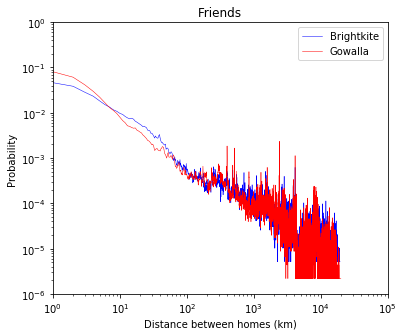

In [45]:
# Let's plot the two distributions on a logscale
# Plot
plt.figure(figsize=(6,5))
# Lines
plt.loglog(dist_bk,p_bk,linewidth=0.5,color='blue',linestyle='-',)
plt.loglog(dist_gw,p_gw,linewidth=0.5,color='red',linestyle='-',)
# set axis limits as in paper
plt.xlim(1,1e5)
plt.ylim(1e-6,1)
plt.xlabel('Distance between homes (km)')
plt.ylabel('Probability')
plt.legend(['Brightkite','Gowalla'])
plt.title('Friends');

We can clearly see the shape of the distributions as presented in the paper. However, we have a lot of noise especially with big distances as logging the xaxis compresses the values. We will get rid of this noise by computing the cdf instead of pmf. Later, we will compute it's derivative but by changing exponentially the step size in the next section to obtain a smooth pmf.

### 4.9.3. Compute cdfs and it's derivative (with changing step) and display  distance distribution

In [46]:
def get_pmf_2(vals):
    """
    This function computes the pmf by differentiating the cdf. The deltaX of the differentiation is constant
    in a logarithmic scale. The purpose of that is obtain a smooth pmf curve in logarithmic scale.
    
    Input: 
    -- vals: an np.array of positive integers
    Output:
    -- val: unique values of the array vals;
    -- p: probability of occurance of each value in val
    
    """ 
    # Compute cdf
    y = np.cumsum(np.bincount(vals)[1:])
    y = y / y[-1]
    x = list(range(1, max(vals) + 1))
    
    # Compute it's derivative (the step size of the gradient is increasing exponentially)
    # Redistribute the x vector in logspace
    val = np.logspace(0,np.log2(np.max(x)),base=2,num=50)
    # Interpolate the cdf with respect to the previously defined vector 
    log_y = np.interp(val,x,y)
    # Compute the gradient of log_y with respect to val
    p = np.gradient(log_y,val)
    # Correct p 
    p = p/np.sum(p)
    
    return val, p

In [47]:
# Recompute the distributions using the new pmf function
dist_bk,p_bk = get_pmf_2(df_dist_brightkite.distance.values)
dist_gw,p_gw = get_pmf_2(df_dist_gowalla.distance.values)

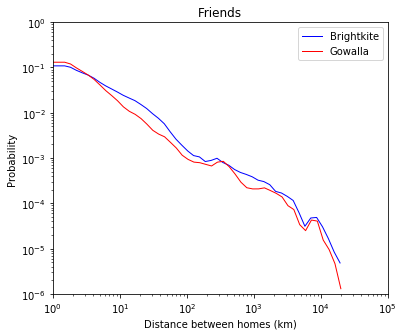

In [48]:
# Let's plot these two new distributions on a logscale
# Plot
plt.figure(figsize=(6,5))
# Lines
plt.loglog(dist_bk,p_bk,linewidth=1,color='blue',linestyle='-')
plt.loglog(dist_gw,p_gw,linewidth=1,color='red',linestyle='-')
# set axis limits as in paper
plt.xlim(1,1e5)
plt.ylim(1e-6,1)
plt.xlabel('Distance between homes (km)')
plt.ylabel('Probability')
plt.legend(['Brightkite','Gowalla'])
plt.title('Friends');

Now, we have much cleaner distributions. We will use it then in replicating Fig 2.a of the paper.

### 4.9.4 Replication Fig 2.a

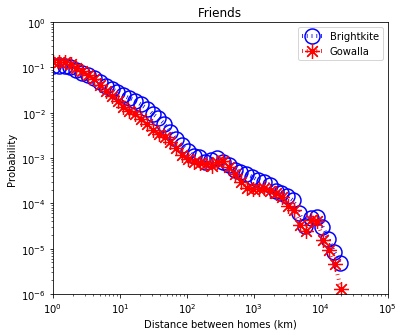

In [49]:
# Plot
plt.figure(figsize=(6,5))
# Brightkite distribution
plt.loglog(dist_bk,p_bk,linewidth=4,color='blue',linestyle= (0,(0.2,1)),
            marker = 'o',markeredgecolor='blue',markerfacecolor='none',ms=15,mew=1.5)
# Gowalla distribution
plt.loglog(dist_gw,p_gw,linewidth=4,color='red',linestyle= (0,(0.2,1)),
           marker = (8, 2),markeredgecolor='red',markerfacecolor='none',ms=15,mew=1.25)

# set axis limits as in paper
plt.xlim(1,1e5)
plt.ylim(1e-6,1)
plt.xlabel('Distance between homes (km)')
plt.ylabel('Probability')
plt.legend(['Brightkite','Gowalla'])
plt.title('Friends');

## 4.10 Discussion

For this assignment, I tried to replicate Fig 2.a from the paper Frindship and Mobility written by E. Cho, S. A. Myers, and J. Leskovec. 

I tried to replicate the same steps discribed in the second section of paper:

1. Discretizing the world into 25x25$km^2$
2. Find users' homes coordinates by averaging check-ins locations in the most visited square
3. Compute distance between friends'homes
4. Plot distance distributions

In addition to that, I corrected the longitude and latitude which contained some erroneous data for some users.
I also removed duplicated friendships from edges dataframes. These two steps were not described in the paper.

The figure we obtain is very similar to the proposed one in the paper. We can see the kink around 100km both in Gowalla and brightkite data.

Morover, I underestimated the number of hours needed to replicate this figure. I took me around 10 hours of work and up to 2 more for executing and checking some scripts.

# 5. Quantifying friendship effect on user movement

As explained in the paper, the goal of this step is to show that long distance friendship network influences user's movements the most. To do that, we need to compute $P_{data}$ which consits of the fraction of friend visiting checkins with respect to the traveled distance from home. Then, we need to compare it to a null model, $P_{null}$, where users checkin randomly according to the population density.

In the following steps, we will mainly use functions to avoid storing intermediate calculation and unnecessarly fill our RAM.

## 5.1 Compute checkin distance from home

Defining a function to compute distance between two geographic coordiantes

In [50]:
def compute_distance(df,columns):
    '''
    This function computes the distance between two geographic coordinates for a given dataframe.
    
    Input: 
        - df: Dataframe containing 4 columns latitude1, longitude1, latitude2 and longitude2
        - columns: list of columns [latitude1, longitude1, latitude2 and longitude2]
        
    Output: 
        - numpy array containing the distance between geographic coordinates of each row
    '''
    points1 = list(zip(df[columns[0]],df[columns[1]]))
    points2 = list(zip(df[columns[2]],df[columns[3]]))
    # Use harvesine_vector to compute the distance between points
    return np.round(haversine_vector(points1,points2,Unit.KILOMETERS)).astype(int)

Defining a function to merge users checkins and users home location

In [51]:
def compute_checkin_distances_from_home(df_checkins,df_home_locations):
    '''
    This function compute checkin distance from home
    
    Input:
        - df_checkins: Dataframe containing users checkins
        - df_home_locations: Dataframe containing users homes' location
        
    Ouput:
        - df_tmp: Dataframe containing users checkins locations and distance from home
    '''
    
    # Merging df_checkins with users home location
    df_tmp = df_checkins.merge(df_home_locations, on = 'user',suffixes=('_Checkins','_Home'))
    
    # Computing checkin distance from home
    df_tmp['check_in_distance_from_home'] = compute_distance(df_tmp,df_tmp.columns[1:])
    
    # Dropping unnecessary columns
    df_tmp.drop(columns=['latitude_Home','longitude_Home'],inplace=True)
    
    return df_tmp

In [52]:
# Compute and display an example from gowalla's data 
checkins_distance_example = compute_checkin_distances_from_home(df_gowalla_totalCheckins.sample(frac=0.01),
                                    users_gowalla_home_location)
checkins_distance_example.head()

,user,latitude_Checkins,longitude_Checkins,check_in_distance_from_home
0,58931,35.943315,-115.117095,6
1,58931,35.941658,-115.116568,7
2,4860,33.686104,-117.919067,13
3,4860,33.806972,-118.153946,13
4,4860,33.761460,-118.022561,1


## 5.2 Identify checkins near friend home

In the paper, they consider that a user is visiting his friend of his checkin location is at 25 km from a friend home. We define the function below for this purpose.

In [53]:
def moved_close_to_friend(df,columns):
    '''
    This function classify checkins users checkins. If the latter is at 25 km from a friend's home, the label
    is True and False otherwise.
    
    Input:
        - df: Dataframe containing columns latitude1,longitude1,latitude2 and longitude2 where latitude1 
              and longitude1 identify the user's friend home location while latitude2 and 
              longitude2 are the user checkins
        - columns: list of columns [latitude1, longitude1, latitude2 and longitude2]
        
    Output:
        - numpy array of classified checkins
    '''
    dist = compute_distance(df,columns)
    return dist<=25

To compute the fraction of fraction of friend visiting we first need to compute checkins distance of the user to it's friends homes. As we deleted the duplicated edges in section 3.2, we will add them back using the function below. Basically, this will replace the undirected edges by a two way directed edges.

In [54]:
def build_two_way_edges(df):
    '''
    This function extend an undirected edge dataframe by appending the other direction to the dataframe.
    The result is a two way directed edges.
    
    Input:
        - df: undirected edge dataframe
    
    Output:
        - a two way directed edge dataframe
    '''
    return df.append(df.rename(columns={"user1": "user2", "user2": "user1"}))

Now we will define a function that computes that classify the checkins.

In [55]:
def compute_checkins_near_friend_home(df_edges,df_checkins,df_home_location):
    '''
    This function classify users checkins by computing the distance from users checkins to his friends
    homes. If the distance is smaller than 25km it is classified as True which means that the user has 
    visited his home.
    
    Input:
        - df_edges: Dataframe of an undirected friendship graph containing rows: 'user1' and 'user2'
        - df_checkins: Dataframe of user1 checkins must contain rows: 'user', 'latitude' and longitude
        - df_home_location: Dataframe containing users id and their respective home location: must contain
                            rows 'user', 'latitude' and 'longitude'
                            
    Output:
        - df_tmp: Dataframe containing classified checkins. If the user has checked near a friend's home
                  return True and False otherwise.
    '''
    
    # Build an two way edges dataframe from an undirected one
    df_edges_tmp = build_two_way_edges(df_edges)
    
    # Merging the edges dataframe with home location on user2 to obtain user1 friends' home locations
    df_tmp =  df_edges_tmp.merge(df_home_location,left_on='user2',right_on='user')
    
    # Merging the previously defined dataframe with checkins of user1
    df_tmp = df_tmp.merge(df_checkins,left_on='user1',right_on='user')
    
    # Selecting columns for the classification function
    columns = ['latitude','longitude','latitude_Checkins','longitude_Checkins']
    
    # Classify the checkins
    df_tmp['close_to_friend'] = moved_close_to_friend(df_tmp,columns)
    
    # We need to have a single lable for every checkin. But now, we have several labels 
    # for the same checkin as we compare the checkin location with all friend's home locations list.
    # To fix this issue, we simply need to group by the 'user1','latitude_checkins' and 'longitude_checkins'
    # and agg with the mean for the check_in_distance_from home and max for 'close_to_friend' columns.
    # The 'max' operation basically acts as an 'or' gate.
    
    df_tmp = df_tmp.drop(columns=['latitude','longitude','user2']).\
                    groupby(['user1','latitude_Checkins','longitude_Checkins']).\
                    agg({'check_in_distance_from_home': 'mean','close_to_friend': 'max'})
    
    return df_tmp

In [56]:
# Display an example
compute_checkins_near_friend_home(df_gowalla_edges,checkins_distance_example,
                                  users_gowalla_home_location).head()

check_in_distance_from_home  \
user1 latitude_Checkins longitude_Checkins                                
0     30.262801         -97.725068                                    3   
      37.759689         -122.427177                                2413   
      37.761445         -122.423959                                2413   
      39.191054         -106.821249                                1291   
2     34.013604         -118.491869                                 544   

                                            close_to_friend  
user1 latitude_Checkins longitude_Checkins                   
0     30.262801         -97.725068                     True  
      37.759689         -122.427177                    True  
      37.761445         -122.423959                    True  
      39.191054         -106.821249                    True  
2     34.013604         -118.491869                    True

## 5.3 Compute the number of checkins near a friend's home

Now, we have all the needed functions to compute the number of checkins near a friend's home. We define the function below group all the calculations

In [57]:
def compute_df_P(df_edges,df_checkins,df_home_location, sample_frac = 1):
    '''
    This function takes all the needed dataframes to construct a dataframe conaining the total number of
    checkins and the number of checkins near a friends. It uses the following functions:
    . compute_checkin_distances_from_home
    . compute_checkins_near_friend_home
    
    Input:
        - df_edges: Dataframe of undirected edges
        - df_checkins: Dataframe of users checkins
        - df_home_location: Dataframe of users home location
        - sample_frac: a strictly positive float smaller than one. It's used to sample df_checkins
    
    Output:
        - Dataframe containing the totoal number of checkins and the number of visits to a friend
    '''
    
    # Sample checkins dataframe
    df_checkins_tmp = df_checkins.sample(frac = sample_frac)
    
    # Compute checkins distance from home
    df_tmp = compute_checkin_distances_from_home(df_checkins_tmp,df_home_location)
    
    # Classify checkins
    df_tmp = compute_checkins_near_friend_home(df_edges,df_tmp,df_home_location)
    
    # Count the number of checkins and the number of friends' visits   
    df_tmp = df_tmp[['check_in_distance_from_home','close_to_friend']].\
                    groupby('check_in_distance_from_home').agg(['sum','count']).\
                    rename(columns={'sum': '# visits to friend','count': '# checkins'})
    
    # Sort the dataframe according to the check_in_distance_from_home
    df = df_tmp.close_to_friend.sort_index()
    
    # Remove rows with 0 values and return result
    return df.loc[~(df==0).all(axis=1)]

## 5.4. Compute Dataframe of $P_{data}$

In [58]:
df_P_data_gowalla =  compute_df_P(df_gowalla_edges,df_gowalla_totalCheckins,
                                 users_gowalla_home_location,sample_frac=0.1)

df_P_data_brightkite =  compute_df_P(df_brightkite_edges,df_brightkite_totalCheckins,
                                 users_brightkite_home_location,sample_frac=0.1)

In [59]:
# Display an example
df_P_data_brightkite.head()

,# visits to friend,# checkins
check_in_distance_from_home,,
0,10267,14792
1,18235,21145
2,15099,17228
3,11610,13119
4,9190,10337


## 5.5. Compute Dataframe of $P_{null}$

Now that we computed $P_{data}$, let's compute $P_{null}$

### 5.5.1. Constructing a randomized checkin dataframe

As explained in the paper, $P_{null}$ is computed using random checkins with respect to the population density.
To do that, we simply take the checkins dataframe, randomly sample the users and assign to every row a random pair of latitude longitude sampled from the same dataframe.

In [60]:
def construct_randomized_checkins(df_checkins,sample_frac=1):
    '''
    This function takes a checkin dataframe containing user id and the location of the checkin and build 
    a randomized version of this dataframe.
    
    Input:
        - df_checkins: Checkin dataframe containing rows: 'user', 'latitude' and 'longitude'
    
    Output:
        - df_tmp: A randomized version of df_checkins
    
    '''
    
    # Define the random state
    random_state = np.random.RandomState()
    
    # Building a randomized version
    # Note that we set the replace parameter at True to keep the same distribution while sampling from
    # df_checkins
    df_tmp = pd.DataFrame()
    df_tmp['user'] = df_checkins.user.sample(frac = sample_frac,replace = True,random_state = random_state).values
    df_tmp[['latitude','longitude']] = df_checkins[['latitude','longitude']].\
                                      sample(frac = sample_frac,replace = True,random_state = random_state).values
    return df_tmp

Constructing random checkins from Gowalla and Brightkite datasets

In [61]:
df_gowalla_randomCheckins = construct_randomized_checkins(df_gowalla_totalCheckins,sample_frac = 1)
df_brightkite_randomCheckins = construct_randomized_checkins(df_brightkite_totalCheckins,sample_frac = 1)

### 5.5.2. Compute $P_{null}$ dataframe using the randomized checkins

Computing $P_{null}$ for both Gowalla and Brightkite random checkins

In [62]:
df_P_null_gowalla =  compute_df_P(df_gowalla_edges,df_gowalla_randomCheckins,
                                 users_gowalla_home_location,sample_frac=0.1)

df_P_null_brightkite =  compute_df_P(df_brightkite_edges,df_brightkite_randomCheckins,
                                 users_brightkite_home_location,sample_frac=0.1)

In [63]:
# Display an example
df_P_null_gowalla.head()

,# visits to friend,# checkins
check_in_distance_from_home,,
0,130,150
1,739,784
2,778,838
3,662,709
4,544,581


## 5.6. Computing the fraction of checkins near a friend's home

Now we have a dataframe composed of the total number of checkins and the number of visits to a friend.
Therefore, we can use this result to compute the fraction of friends visits for both $P_{data}$ and $P_{null}$.

In [64]:
def compute_P(df_P):
    
    '''
    This function takes a dataframe containing the total number of users checkins and the number of visits to
    a friend, compute the fraction of friends' visits. Then it interpolates the resulting vector according to
    a logspace vector.
    
    Input:
        - A Dataframe containing rows 'check_in_distance_from_home','# visits to friend' and '# checkins' 
    Output:
        - x: a logspace vector between 25, and 15000 containing 17 points
        - y: an interpolation 
    '''
    
    # Computing the P from df_P
    fraction = df_P['# visits to friend']/df_P['# checkins']
    
    # Constructing a logspace vector
    # Note: The limits are chosen to match the figures of the paper
    x = np.logspace(np.log10(25),np.log10(1.5e4),17)
    
    # Averaging fraction values between the bounds of the logspace vector
    # Initialize lower_bound
    lower_bound = 0
    y = []
    for i in range(len(x)) :
        # Set upperbound
        upper_bound = x[i]
        # compute mask
        mask = (df_P.index >=lower_bound) & (df_P.index<upper_bound)
        # compute mean
        mean_tmp = np.mean(fraction[mask])
        # append mean to y vector
        y.append(mean_tmp)
        # update lower_bound
        lower_bound = x[i]
    
    return x, y

## 5.7. Replicating Fig. 3.a

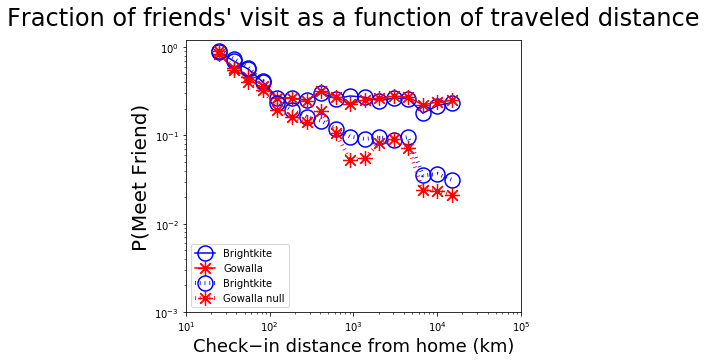

In [65]:
# Computing P_null
x_gw_null, y_gw_null = compute_P(df_P_null_gowalla)
x_bk_null, y_bk_null = compute_P(df_P_null_brightkite)

# Computing P_data
x_gw_data, y_gw_data = compute_P(df_P_data_gowalla)
x_bk_data, y_bk_data = compute_P(df_P_data_brightkite)

# Plot
plt.figure(figsize=(6,5))
# P Data
plt.loglog(x_bk_data,y_bk_data,color='blue',linewidth=1.5,linestyle='-',
           marker = 'o',markeredgecolor='blue',markerfacecolor='none',ms=15,mew=1.5)
plt.loglog(x_gw_data,y_gw_data,color='red',linewidth=1.5,linestyle='-',
           marker = (8, 2),markeredgecolor='red',markerfacecolor='none',ms=15,mew=1.25)

# P Null
plt.loglog(x_bk_null,y_bk_null,linewidth=4,color='blue',linestyle= (0,(0.2,1)),
           marker = 'o',markeredgecolor='blue',markerfacecolor='none',ms=15,mew=1.5)
plt.loglog(x_gw_null,y_gw_null,linewidth=4,color='red',linestyle= (0,(0.2,1)),
           marker = (8, 2),markeredgecolor='red',markerfacecolor='none',ms=15,mew=1.25)

# Set axis limits to match paper figure
plt.xlim(10,1e5)
plt.ylim(1e-3,1.2)

plt.legend(['Brightkite','Gowalla','Brightkite','Gowalla null'],loc = 'lower left')
plt.xlabel('Check−in distance from home (km)',fontsize=18)
plt.ylabel('P(Meet Friend)',fontsize=20)
plt.title('Fraction of friends\' visit as a function of traveled distance',pad=15,fontsize=24)


plt.show()

## 5.8. Replicating Fig. 3.b

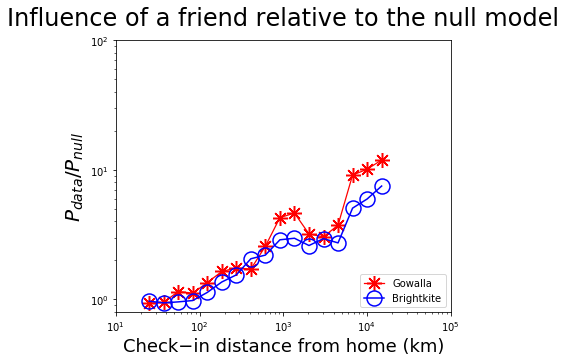

In [66]:
# Divide P_data over P_Null

# Gowalla
x_gw = x_gw_data
y_gw = np.array(y_gw_data)/np.array(y_gw_null)

#Brightkite
x_bk = x_bk_data
y_bk = np.array(y_bk_data)/np.array(y_bk_null)

# Plot
plt.figure(figsize=(6,5))

plt.loglog(x_gw,y_gw,marker = (8, 2),markeredgecolor='red',markerfacecolor='None',ms=15,mew=1.5,
           color='red',lw=1.25)
plt.loglog(x_bk,y_bk,marker = 'o',markeredgecolor='blue',markerfacecolor='None',ms=15,mew=1.5,
           color='blue',lw=1.5)

# Set axis limits to match paper figure
plt.xlim(10,1e5)
plt.ylim(0.8,100)

plt.legend(['Gowalla','Brightkite'],loc='lower right')
plt.xlabel('Check−in distance from home (km)',fontsize=18)
plt.ylabel('$P_{data} /P_{null}$',fontsize=20)
plt.title('Influence of a friend relative to the null model',pad=15,fontsize=24)

plt.show()

## 5.8 Discussion

For this assignment, I tried to reproduce Fig 3.a and 3.b of the paper.
I obtained qualitatively similar results for both Gowalla and Brightkite datasets.

It was not possible to reproduce exactly the same figure for the following reasons:
- The computation of P_null was not explained in details in the paper
- The computation of P_null require the construction random checkins for every user according to the population density.

To conclude, my replication is aligned with the presented results found in the paper. We can clearly see that long distance friendships affect our movement the most when we compare the fraction of friends' visits over the number of checkins at that given distance to a null model.